# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# create a Spark session
spark = SparkSession     .builder     .appName("Sparkify")     .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Load in full sparkify dataset

sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
#Clean Dataset
df.count()
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()
df = df.filter(df.userId!="")
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
df.select("page").dropDuplicates().show()
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
+------+
only showing top 10 rows



In [10]:
# adding time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

+------+----+----+-----+----+---------+
|userId|page|time|level|song|sessionId|
+------+----+----+-----+----+---------+
+------+----+----+-----+----+---------+

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



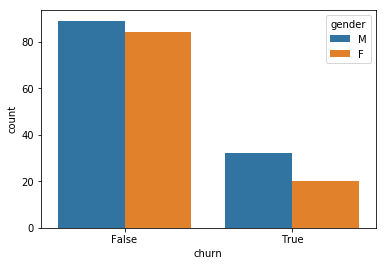

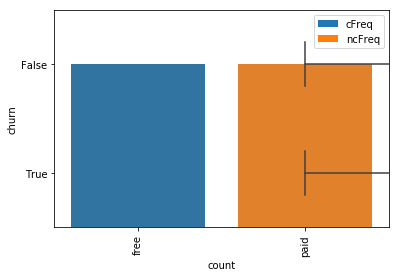

In [11]:
df.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df.userId == "296").sort("time").show(100)
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list))
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)
churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page")
df_pd = df_withchurn.filter(df_withchurn.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd)
df_withchurn.select("time").describe().show()
df_pd = df_withchurn.groupby("churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='churn', orient="h", data=df_pd)
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_withchurn = df_withchurn.withColumn("hour", get_hour(df_withchurn.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_withchurn = df_withchurn.withColumn("weekday", get_weekday(df_withchurn.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_withchurn = df_withchurn.withColumn("day", get_day(df_withchurn.ts))

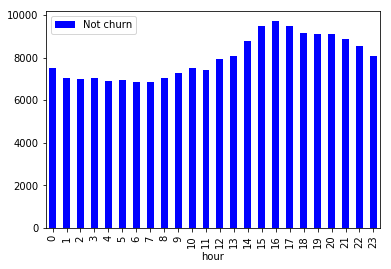

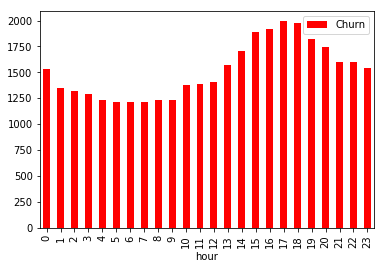

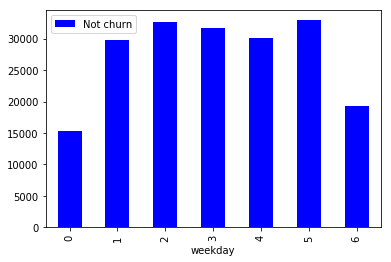

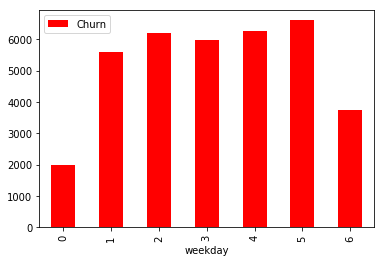

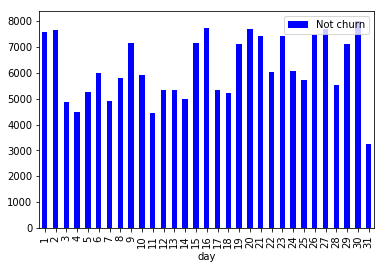

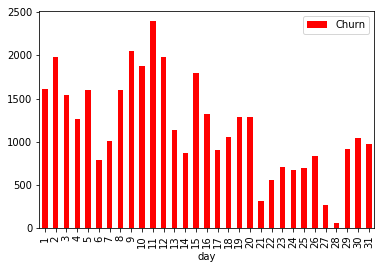

In [12]:
def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = df_withchurn.filter(df_withchurn.page == "NextSong").groupby("churn", time).count().orderBy(df_withchurn[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    df_pd[df_pd.churn==0].plot.bar(x=time, y='count', color='Blue', label='Not churn')
    df_pd[df_pd.churn==1].plot.bar(x=time, y='count', color='Red', label='Churn')
plot_cnt_by_churn("hour")
plot_cnt_by_churn("weekday")
plot_cnt_by_churn("day")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [13]:
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

user_reg_days.show(5)
user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")
user_session_time_stat.show(5)
user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")
user_session_songs_avg.show(5)
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")
user_session_count.show(5)
user_gender = df_withchurn.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

user_gender.show(5)
user_paid = df_withchurn.groupby("userId", "level").agg(max(df_withchurn.ts).alias("finalTime")).sort("userId")
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))
user_recent_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finalTime]).select(user_paid.userId, "level").sort("userId")
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))

user_recent_level.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows

+------+------------------+-----------------+------------------+
|userId|    avgSessionTime|   minSessionTime|    maxSessionTime|
+------+------------------+-----------------+------------------+
|    10|459.74722222222226|91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|              0.0|1019.5833333333334|
|100001|148.15833333333333|             63.0|215.28333333333333|
|100002|201.18333333333334|              0.0| 730.4666666666667|
|100003| 99.11666666666667|3.216666666666667|195.01666666666668|
+------+------------------+-----------------+------------------+
only showing top 5 rows

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|

In [14]:
# showing all type of page
page_list = [(row['page']) for row in df_withchurn.select("page").dropDuplicates().collect()]

In [15]:
# removing the column which will cause data leakage
page_list.remove("Cancel")
page_list.remove("Cancellation Confirmation")

In [16]:
# calculating the total page each user view
user_page_view_count = df_withchurn.groupby("userId").count()
user_page_view_count = user_page_view_count.withColumnRenamed("count", "pageCount")

for page in page_list:
    col_name = "count" + page.replace(" ", "")
    view_count = df_withchurn.filter(df_withchurn.page==page).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdTemp")
    user_page_view_count = user_page_view_count.join(view_count, user_page_view_count.userId==view_count.userIdTemp, "left").drop("userIdTemp")
user_page_view_count = user_page_view_count.sort("userId")
user_page_view_count = user_page_view_count.fillna(0)
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_count.createOrReplaceTempView("user_page_view_count")
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_freq = spark.sql(freq_sql)

user_page_view_freq.show(5)
user_artist_count = df_withchurn.filter(df_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")
user_artist_count.show(5)
user_churn = df_withchurn.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))
user_churn.show(5)

+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+
|userId| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|
+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+----------------

In [17]:
# put all the features dataframe into a list
features_list = []
features_list.append(user_reg_days)
features_list.append(user_session_time_stat)
features_list.append(user_session_songs_avg)
features_list.append(user_session_count)
features_list.append(user_gender)
features_list.append(user_recent_level)
features_list.append(user_page_view_freq)
features_list.append(user_artist_count)
features_list.append(user_churn)

In [18]:
# prepare the final dataframe to join all the other features
df_final = df_withchurn.select("userId").dropDuplicates()

In [19]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [20]:
# use function to merge the features in the list
for feature in features_list:
    df_final = features_merge(df_final, feature)

# sort and view the final dataframe
df_final = df_final.sort("userId")
df_final.persist()
df_final.show(5)

+------+------------------+------------------+-----------------+------------------+------------------+------------+------+-----+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+-----------+-----+
|userId|            regDay|    avgSessionTime|   minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|level| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|aritstCount|churn|
+------+------------------+-------------

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [21]:
df_final.groupby("churn").count().show()
out_path = "final_data.csv"
df_final.write.save(out_path, format="csv", header=True)

df_final = spark.read.csv(out_path, header=True)
df_final.persist()

num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [22]:
assembler = VectorAssembler(inputCols=df_final.columns[1:-1], outputCol="NumFeatures")
data = assembler.transform(df_final)

scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

data = data.select(data.churnNum.alias("label"), data.ScaledNumFeatures.alias("features"))

train, validation = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

lr =  LogisticRegression()
paramGrid = ParamGridBuilder()     .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0])     .addGrid(lr.regParam,[0.0, 0.05, 0.1])     .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval.fit(train)

cvModel_lr.save('cvModel_lr.model')

cvModel_lr.avgMetrics
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder()     .addGrid(dt.impurity,['entropy', 'gini'])     .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8])     .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train)

cvModel_dt.save('cvModel_dt.model')

cvModel_dt.avgMetrics

[0.7760356855981378,
 0.7864456431502405,
 0.7733574899730469,
 0.7277127148556533,
 0.7326814587694896,
 0.7273174211259148,
 0.7350669036700854,
 0.7919373059593184,
 0.7768523538226852,
 0.7890862394450029,
 0.7150580060210645,
 0.7198638104527632,
 0.7132539649034881,
 0.7132539649034881]

In [23]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder()     .addGrid(gbt.maxIter,[3, 10, 20])     .addGrid(gbt.maxDepth,[2, 4, 6, 8])     .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)

cvModel_gbt.save('cvModel_gbt.model')

cvModel_gbt.avgMetrics
stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
stratified_train.groupby("label").count().show()
lrs =  LogisticRegression()
paramGrid = ParamGridBuilder()     .addGrid(lrs.elasticNetParam,[0.0, 0.1, 0.5, 1.0])     .addGrid(lrs.regParam,[0.0, 0.05, 0.1])     .build()

crossval_lrs = CrossValidator(estimator=lrs,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lrs = crossval_lrs.fit(stratified_train)
cvModel_lrs.avgMetrics
cvModel_lrs.save('cvModel_lrs.model')

dts = DecisionTreeClassifier()
paramGrid = ParamGridBuilder()     .addGrid(dts.impurity,['entropy', 'gini'])     .addGrid(dts.maxDepth,[2, 3, 4, 5, 6, 7, 8])     .build()
crossval_dts = CrossValidator(estimator=dts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_dts = crossval_dts.fit(stratified_train)
cvModel_dts.avgMetrics
cvModel_dts.save('cvModel_dts.model')

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   44|
|  0.0|   35|
+-----+-----+



In [28]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder()     .addGrid(gbts.maxIter,[3, 10, 20])     .addGrid(gbts.maxDepth,[2, 4, 6, 8])     .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_gbts = crossval_gbts.fit(stratified_train)
cvModel_gbts.avgMetrics

cvModel_gbts.save('cvModelfinal_gbts.model')

results = cvModel_lr.transform(validation)



In [29]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

results = cvModel_lrs.transform(validation)

tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

cvModel_lrs.bestModel.coefficients
df_final.columns


0.5
0.25
0.3333333333333333
0.46153846153846156
0.75
0.5714285714285714


['userId',
 'regDayNum',
 'avgSessionTimeNum',
 'minSessionTimeNum',
 'maxSessionTimeNum',
 'avgSessionSongsNum',
 'sessionCountNum',
 'genderNum',
 'levelNum',
 'freqSubmitDowngradeNum',
 'freqThumbsDownNum',
 'freqHomeNum',
 'freqDowngradeNum',
 'freqRollAdvertNum',
 'freqLogoutNum',
 'freqSaveSettingsNum',
 'freqAboutNum',
 'freqSettingsNum',
 'freqAddtoPlaylistNum',
 'freqAddFriendNum',
 'freqNextSongNum',
 'freqThumbsUpNum',
 'freqHelpNum',
 'freqUpgradeNum',
 'freqErrorNum',
 'freqSubmitUpgradeNum',
 'aritstCountNum',
 'churnNum']

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.